***A basic sentiment analysis tool that classifies text as positive, negative, or neutral.***


In [2]:
# Import libraries and dataset
import pandas as pd
import nltk
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import random
import string
import os

In [3]:
# Fetch the movie_reviews dataset
nltk.download('movie_reviews')
nltk.download('stopwords')

# Create a list of tuples 
# Each tuple contains information of the review and the review category
# The outer loop iterates over each review category
# The inner loop iterates over the file IDs associated with the category
content = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

# Checking if the variable 'content' has been loaded correctly
print("Sample of original content (first 5 documents):")
for i in range(5):
    print(content[i])

# Shuffles the content
random.shuffle(content)

# Preprocess the text content
# Define stop words
stop_words = set(stopwords.words('english'))

# Define the function to clean text content
# To remove stop words and punctuations
def clean_content(words):
    words = [word.lower() for word in words if word.lower() not in stop_words and word not in string.punctuation]
    return ' '.join(words)

# Apply the function
cleaned_content = [(clean_content(words), category) for words, category in content]

# Checking the cleaned content
print("Sample of the cleaned content (first 5 documents):")
for i in range(5):
    print(cleaned_content[i])

# Convert the cleaned content to a dataframe and save as csv
# Specify a path where I have write permissions using the os library
# This line of code below returns the path to the home directory
home_directory = os.path.expanduser('~')
# And this line of code below creates a full file path
# Through joining a directory path with the name of a file
file_path = os.path.join(home_directory, 'movie_reviews_dataset.csv')
df = pd.DataFrame(cleaned_content, columns=['review', 'sentiment category'])
df.to_csv(file_path, index=False)


[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/ella/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ella/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sample of original content (first 5 documents):
(['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his', 'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',', 'and', 'has', 'nightmares', '.', 'what', "'", 's', 'the', 'deal', '?', 'watch', 'the', 'movie', 'and', '"', 'sorta', '"', 'find', 'out', '.', '.', '.', 'critique', ':', 'a', 'mind', '-', 'fuck', 'movie', 'for', 'the', 'teen', 'generation', 'that', 'touches', 'on', 'a', 'very', 'cool', 'idea', ',', 'but', 'presents', 'it', 'in', 'a', 'very', 'bad', 'package', '.', 'which', 'is', 'what', 'makes', 'this', 'review', 'an', 'even', 'harder', 'one', 'to', 'write', ',', 'since', 'i', 'generally', 'applaud', 'films', 'which', 'attempt', 'to', 'break', 'the', 'mold', ',', 'mess', 'with', 'your', 'head', 'and', 'such', '(', 'lost', 'highway', '&', 'memento', ')

In [4]:
# Import the dataset
reviews_df = pd.read_csv('movie_reviews_dataset.csv')
print(reviews_df.dtypes)
reviews_df.head(10)

review                object
sentiment category    object
dtype: object


,review,sentiment category
0,lake placid marks yet another entry series pre...,neg
1,anastasia contains something lacking recent di...,pos
2,october 1962 united states found brink nuclear...,pos
3,like wonderful 1990 drama awakenings starring ...,pos
4,walked crouching tiger hidden dragon thought s...,pos
5,battle dreamworks versus disney earlier year m...,pos
6,jerry springer got nothing wild things john mc...,pos
7,nothing like american history x theaters video...,pos
8,reasonable human would must admit occasionally...,neg
9,deceiver plot twist search movie overly constr...,neg


In [15]:
# Preprocess the data
# Check for missing values
print(reviews_df.isnull().sum())
# No missing values

review                0
sentiment category    0
dtype: int64


In [6]:
# Conduct explanatory data analysis
reviews_df.describe()

,review,sentiment category
count,2000,2000
unique,1998,2
top,seemed like perfect concept better farrelly br...,neg
freq,2,1000


***It seems that the same two review have both appeared twice from the information above. However, because the text content has been cleaned, and stop words and punctuation has been remove, it is hard to tell whether the same review has appeared twice or two similar reviews ended up looking identical after cleaning. Therefore, I will print out the duplicates first before I decide what to do with them.***

In [7]:
# Print out the duplicates
duplicates = reviews_df[reviews_df.duplicated(subset=['review'], keep=False)]
print(duplicates)

                                                 review sentiment category
342   seemed like perfect concept better farrelly br...                neg
614   tagline film houses born bad expect much prese...                neg
1096  tagline film houses born bad expect much prese...                neg
1175  seemed like perfect concept better farrelly br...                neg


***Judging by the result above, the duplicated reviews are the exact same, and are from the same category, which is 'neg'. This means that keeping the duplicates would not necessarily add any additional values to my analysis, so I have decided to remove the duplicates.***

In [8]:
# Remove the duplicates
# Keep the first occurance of the duplicates
reviews_df = reviews_df.drop_duplicates(subset=['review'], keep='first')

# Check the updated dataset
reviews_df.describe()

,review,sentiment category
count,1998,1998
unique,1998,2
top,lake placid marks yet another entry series pre...,pos
freq,1,1000


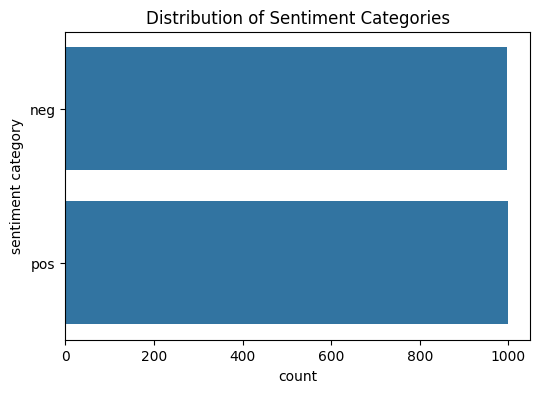

In [16]:
# Check the distribution of the data
plt.figure(figsize=(6,4))
sns.countplot(y='sentiment category', data=reviews_df)
plt.title('Distribution of Sentiment Categories')
plt.savefig('distribution_of_sentiment_categories.png')
plt.show()


In [10]:
# Feature extraction
texts, labels = reviews_df['review'].tolist(), reviews_df['sentiment category'].tolist()

# Initialise the TF-IDK Vectoriser
vectoriser = TfidfVectorizer()

# Convert the text data into TF-IDF features
# Convert the data to arrays so it it easier to work with
X = vectoriser.fit_transform(texts).toarray()
y = labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")



Training set size: (1598, 39516)
Testing set size: (400, 39516)


In [17]:
# Train the model
model = MultinomialNB()

# Fit the model onto the training data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model using accuracy score 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate the classification report
print("Classification report of the Multinomial Naive Bayes model:")
print(classification_report(y_test, y_pred))

Accuracy: 0.785
Classification report of the Multinomial Naive Bayes model:
              precision    recall  f1-score   support

         neg       0.81      0.76      0.79       207
         pos       0.76      0.81      0.78       193

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.78       400
weighted avg       0.79      0.79      0.79       400



***Model Evaluation***

Accuracy score: In this case, the accuracy score of 0.785 suggests that out of all the predictions, 78.5% of them were accurately classified by my model.

Classification report: 

1) Precision: For the neg class, 81% of the reviews predicted as negative were actually negative; for the pos class, 76% of the reviews predicted as positive were actually positive.

2) Recall: For neg class, 76% of the actual negative reviews were correctly identified; for the pos class, 81% of the actual positive reviews were correctly identified.

3) F1-Score: Balances both precision and recall. For the pos class, it is 0.79; for the neg class, it is 0.78.

Overall, this indicates that the model performed fairly well across both the neg and pos classes, with precision, recall and F1-score all within the 0,78-0.81 range. However, there is room for improvement and I will try to optimise the model through experimenting with logistic regression. This is due to the fact that logisitc regression is also a good binary classifier.

In [12]:
from sklearn.linear_model import LogisticRegression
# Initiate the logistic regression model
log_reg_model = LogisticRegression()

# Train the model
log_reg_model.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg_model.predict(X_test)

# Evaluate the model using accuracy score
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log_reg}")

# Print the classification report
print("Classification report for the logistic regression model:")
print(classification_report(y_test, y_pred_log_reg))


Logistic Regression Accuracy: 0.795
Classification report for the logistic regression model:
              precision    recall  f1-score   support

         neg       0.84      0.74      0.79       207
         pos       0.76      0.85      0.80       193

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.79       400
weighted avg       0.80      0.80      0.79       400



***Model Evaluation***

Accuracy score: for the logistic regression model, the accuracy score is 0.795, which means out of all the predictions made by the model, 79.5% of them are accurate, which is 1% higher than the multinomialNB model.

Classification report:

1) Precision: For the neg class, 84% of the reviews predicted as negative were actually negative; for the pos class, 76% of the reviews predicted as positive were actually positive.

2) Recall: For neg class, 74% of the actual negative reviews were correctly identified; for the pos class, 85% of the actual positive reviews were correctly identified.

3) F1-Score: Balances both precision and recall. For the pos class, it is 0.80; for the neg class, it is 0.79.

In conclusion, as suggested by the accuracy score and F1-score, the logistic regression model performs better in this case.
